In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dansbecker/cityscapes-image-pairs
!unzip cityscapes-image-pairs.zip

In [ ]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, save_img
from PIL import Image
from tqdm import tqdm

shutil.rmtree("/content/cityscapes_data/cityscapes_data") #remove extra directory.

In [ ]:
BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map ={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9,10: 10,
               11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20,
               21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30}

def preprocess_image(path):
  img_size = (128, 128)
  img = Image.open(path)
  img1 = (img.crop((0, 0, 256, 256))).resize(img_size)
  img2 = (img.crop((256, 0, 512, 256))).resize(img_size)
  img1 = img_to_array(img1)/255.
  img2 = img_to_array(img2)
  mask = np.zeros(img_size, dtype = np.uint32)
  for row in range(np.shape(mask)[0]):
    for col in range(np.shape(mask)[1]):
      pixel_color = img2[row, col, :]
      final_d = None
      final_key = None
      for key, color in id_map.items():
        #Return the mask color nearest the key color
        d = np.sum(np.sqrt(pow((color - pixel_color), 2))) # Check color distance
        if final_d == None:
          final_d = d
          final_key = key
        elif d < final_d:
          final_d = d
          final_key = key
      mask[row, col] = final_key
  mask = np.reshape(mask, (128, 128, 1))
  return img1, mask

def path_to_target(train_path, val_path):
  list_train = os.listdir(train_path)
  list_val = os.listdir(val_path)
  X_train = np.zeros((len(list_train), 128, 128, 3))
  Y_train = np.zeros((len(list_train), 128, 128, 1))
  X_val = np.zeros((len(list_val), 128, 128, 3))
  Y_val = np.zeros((len(list_val), 128, 128, 1))
  for value in list_train:
    X_train, Y_train = preprocess_image(os.path.join(train_path, value))
  for value in list_val:
    X_val, Y_val = preprocess_image(os.path.join(val_path,value))
  return X_train, Y_train, X_val, Y_val

X_train, Y_train, X_val, Y_val = path_to_target("/content/cityscapes_data/train",
                                                 "/content/cityscapes_data/val")

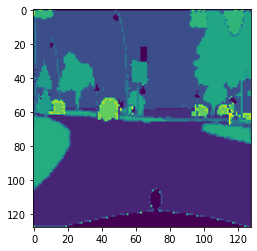

In [ ]:
a, b = preprocess_image("/content/cityscapes_data/train/1.jpg")
plt.imshow(b)

In [ ]:
or_input_dir = "/content/cityscapes_data/train"
input_dir = "/content/data/train"
target_dir = "/content/data/annotations"

for fname in os.listdir(or_input_dir):
  img_path = os.path.join(or_input_dir, fname)
  new_img_train_path = os.path.join(input_dir, fname)
  new_img_target_path = os.path.join(target_dir, fname)
  a = img_to_array(load_img(img_path))  # change 256, 512, 3 image to array
  b = array_to_img(np.split(a, 2, axis=1)[0]) # img for train
  c = array_to_img(np.split(a, 2, axis=1)[1]) # img for annotation
  save_img(new_img_train_path, b)
  save_img(new_img_target_path, c)

In [ ]:
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])
target_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".jpg")])

In [ ]:


img_size = (200, 200)
num_imgs = len(input_img_paths)

# Shuffle the file paths with the same seed
random.Random(1).shuffle(input_img_paths)
random.Random(1).shuffle(target_paths)

def path_to_input_image(path):
 return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
 img = img_to_array(
 load_img(path, target_size=img_size, color_mode="grayscale"))
 img = img.astype("uint8")
 return img

# Load all images into float32 array
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

num_val_samples = 500
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
print(train_input_imgs.shape)
print(train_targets.shape)

(2475, 200, 200, 3)
(2475, 200, 200, 1)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
 inputs = keras.Input(shape=img_size + (3,))
 x = layers.Rescaling(1./255)(inputs)
 x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
 x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 256, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 128, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 64, 3, activation="relu", padding="same", strides=2)(x)
 outputs = layers.Conv2D(num_classes, 3, activation="softmax",
padding="same")(x)
 model = keras.Model(inputs, outputs)
 return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
 keras.callbacks.ModelCheckpoint("city_segmentation.keras",
 save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
 epochs=50,
 callbacks=callbacks,
 batch_size=64,
 validation_data=(val_input_imgs, val_targets))


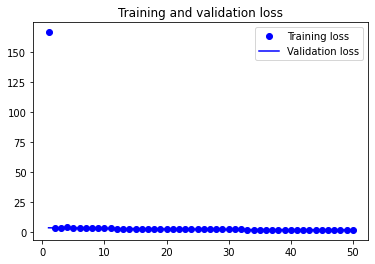

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


In [ ]:
os.mkdir("/content/test")
os.mkdir("/content/test/test")
os.mkdir("/content/test/test_annotations")

In [ ]:
for fname in os.listdir("/content/cityscapes_data/val"):
  a = img_to_array(load_img("/content/cityscapes_data/val/" + fname))  
  b = array_to_img(np.split(a, 2, axis=1)[0]) # img for train
  c = array_to_img(np.split(a, 2, axis=1)[1]) # img for annotation
  save_img("/content/test/test/" + fname, b)
  save_img("/content/test/test_annotations/" + fname, c)


1/1 [==============================] - 0s 158ms/step


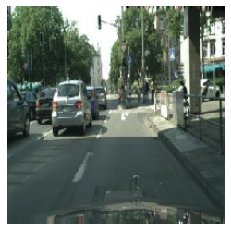

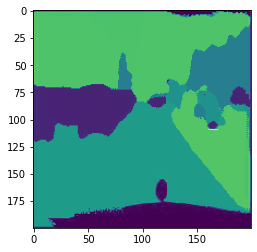

In [ ]:
model =keras.models.load_model("city_segmentation.keras")

i = 1
test_image = path_to_input_image("/content/test/test/"+str(i)."jpg")
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))
plt.figure()
mask = np.argmax(mask, axis = -1)
plt.imshow(mask[0])